# Pneumonia Classification 

## Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

 
  

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Data preprocessing and visualization

In [2]:
# Create a list with the filepaths for training and testing
dir_ = Path('../input/chest-xray-pneumonia/chest_xray/train')
train_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path('../input/chest-xray-pneumonia/chest_xray/test')
test_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path('../input/chest-xray-pneumonia/chest_xray/val')
val_file_paths = list(dir_.glob(r'**/*.jpeg'))

In [3]:
import pandas as pd
from typing import List
from pathlib import Path

def create_image_dataframe(filepaths: List[str]) -> pd.DataFrame:
    """Creates a DataFrame with filepaths and corresponding labels.

    Args:
        filepaths (List[str]): A list of filepaths.

    Returns:
        pd.DataFrame: A DataFrame containing the filepaths and labels.
    """

    labels = [Path(filepath).parent.name for filepath in filepaths]

    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df

train_df = create_image_dataframe(train_file_paths)
val_df = create_image_dataframe(val_file_paths)
# Combine train_df and val_df
train_df = pd.concat([train_df,val_df]).reset_index(drop = True)
test_df = create_image_dataframe(test_file_paths)


print(f'Number of pictures in the training set: {train_df.shape[0]}')
print(f'Number of pictures in the test set: {test_df.shape[0]}')
print(f'Number of pictures in the validation set: {val_df.shape[0]}\n')


print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training set: 5232
Number of pictures in the test set: 624
Number of pictures in the validation set: 16

Number of different labels: 2

Labels: ['PNEUMONIA' 'NORMAL']


Filepath      Label
0  ../input/chest-xray-pneumonia/chest_xray/train...  PNEUMONIA
1  ../input/chest-xray-pneumonia/chest_xray/train...  PNEUMONIA
2  ../input/chest-xray-pneumonia/chest_xray/train...     NORMAL
3  ../input/chest-xray-pneumonia/chest_xray/train...  PNEUMONIA
4  ../input/chest-xray-pneumonia/chest_xray/train...  PNEUMONIA

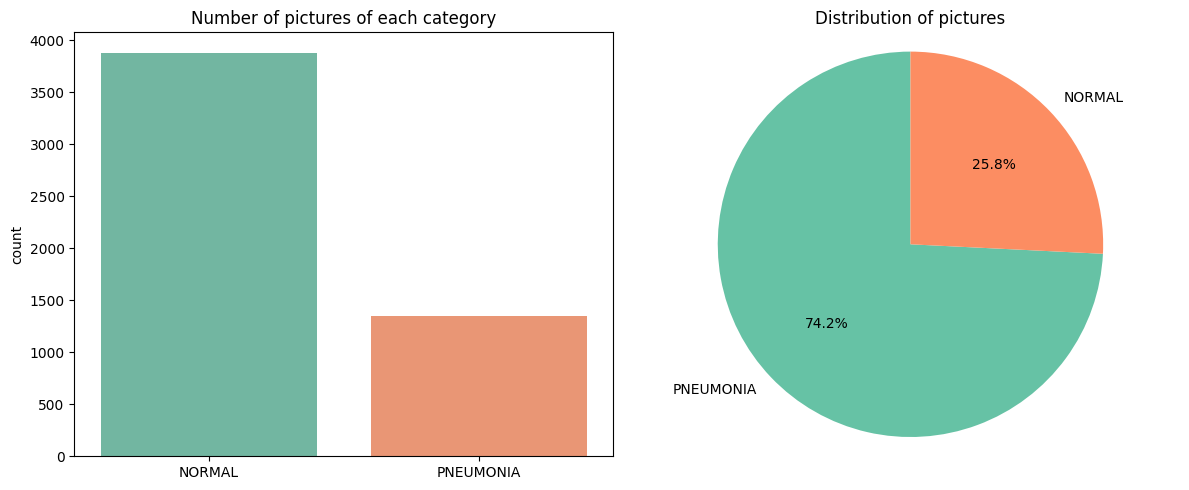

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_category_distribution(df, save_path):
    """Plots and saves a bar plot and a pie chart for the category distribution in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the category data.
        save_path (str): The directory to save the generated images.
    """

    # Display the number of pictures of each category in the DataFrame
    vc = df['Label'].value_counts()

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=sorted(vc.index), y=vc, palette="Set2")
    plt.title("Number of pictures of each category", fontsize=12)

    # Saving the bar plot
    bar_plot_path = os.path.join(save_path, 'category_distribution_bar.png')
    plt.savefig(bar_plot_path)

    # Plotting the pie chart
    plt.subplot(1, 2, 2)
    plt.pie(vc, labels=vc.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    plt.title("Distribution of pictures", fontsize=12)
    plt.axis('equal')

    # Saving the pie chart
    pie_chart_path = os.path.join(save_path, 'category_distribution_pie.png')
    plt.savefig(pie_chart_path)

    plt.tight_layout()
    plt.show()

# Example usage
plot_category_distribution(train_df, '/kaggle/working/')

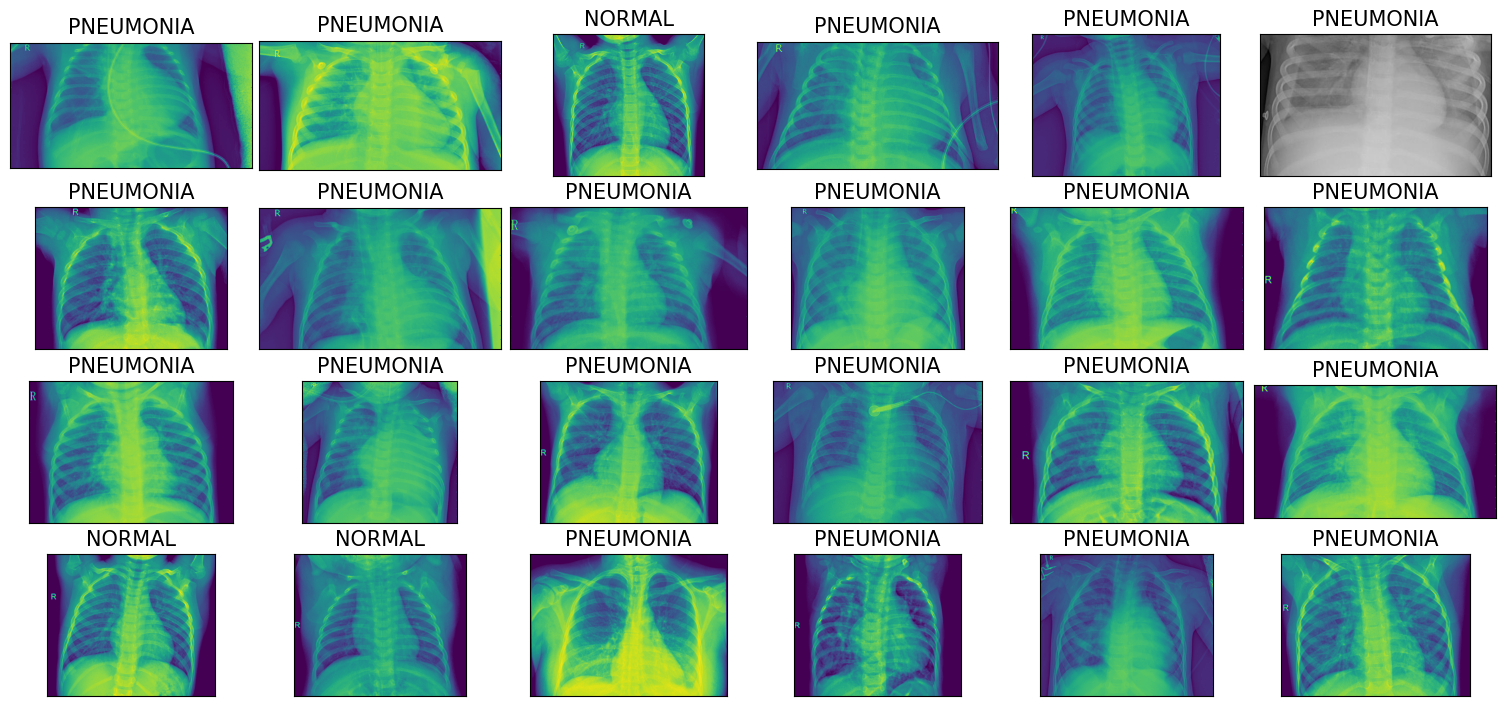

In [5]:
def display_images(df, nrows, ncols, figsize, save_path=None):
    """Displays images from the dataset on subplots and saves the generated image if save_path is provided.

    Args:
        df (pd.DataFrame): The DataFrame containing the image filepaths and labels.
        nrows (int): The number of rows of subplots.
        ncols (int): The number of columns of subplots.
        figsize (tuple): The figure size (width, height) in inches.
        save_path (str, optional): The directory to save the generated image. Defaults to None.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Filepath[i]))
        ax.set_title(df.Label[i], fontsize=15)

    plt.tight_layout(pad=0.5)

    # Saving the generated image if save_path is provided
    if save_path is not None:
        save_file_path = os.path.join(save_path, 'image_display.png')
        plt.savefig(save_file_path)

    plt.show()

# Example usage
display_images(train_df, nrows=4, ncols=6, figsize=(15, 7), save_path='/kaggle/working/')

# 2. Load the Images with a generator and Data Augmentation

In [6]:
def create_gen():
    """
    Create image data generators for training, validation, and testing.

    Returns:
        train_generator (ImageDataGenerator): Image data generator for training data.
        test_generator (ImageDataGenerator): Image data generator for testing data.
        train_images (DirectoryIterator): Iterator for training images.
        val_images (DirectoryIterator): Iterator for validation images.
        test_images (DirectoryIterator): Iterator for testing images.
    """
    # Define common image data generator arguments
    common_args = {
        'preprocessing_function': tf.keras.applications.mobilenet_v2.preprocess_input,
        'class_mode': 'categorical',
        'batch_size': 32,
        'seed': 0,
        'target_size': (224, 224)
    }

    # Define augmentation arguments
    augmentation_args = {
        'rotation_range': 30,
        'zoom_range': 0.15,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'shear_range': 0.15,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }

    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.1,
        **augmentation_args
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

    # Flow from DataFrame arguments
    flow_args = {
        'x_col': 'Filepath',
        'y_col': 'Label',
        'color_mode': 'rgb'
    }

    # Flow from DataFrame for training images
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        subset='training',
        **common_args,
        **flow_args
    )

    # Flow from DataFrame for validation images
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        shuffle=False,
        subset='validation',
        **common_args,
        **flow_args
    )

    # Flow from DataFrame for test images
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        shuffle=False,
        **common_args,
        **flow_args
    )

    return train_generator, test_generator, train_images, val_images, test_images

## 3. Test architectures with pre-trained weights

In [7]:
def create_model(model_class):
    """
    Create a custom model based on a model class.

    Args:
        model_class (tf.keras.Model): Model class.

    Returns:
        model (tf.keras.Model): Custom model.
    """
    # Load the pretrained model
    base_model = model_class(weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create the custom model
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = create_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4709 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


DenseNet121          trained in 121.13 sec
MobileNetV2          trained in 115.8 sec


2023-09-24 21:19:13.587965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB7       trained in 131.19 sec
InceptionResNetV2    trained in 129.06 sec
InceptionV3          trained in 117.81 sec
MobileNetV3Large     trained in 115.23 sec
171446536/171446536 [==============================] - 8s 0us/step
ResNet101            trained in 122.78 sec
94765736/94765736 [==============================] - 5s 0us/step
ResNet50             trained in 116.44 sec
80134624/80134624 [==============================] - 4s 0us/step
VGG19                trained in 118.03 sec
83683744/83683744 [==============================] - 4s 0us/step
Xception             trained in 119.05 sec


In [13]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

20/20 [==============================] - 6s 282ms/step


In [22]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy (test set)','Training time (sec)'])
df_results.sort_values(by='accuracy (test set)', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
# Save df_results to a text file
df_results.to_csv('/kaggle/working/models_results.txt', index=False, sep='\t')
df_results

model  val_accuracy  accuracy (test set)  Training time (sec)
0           ResNet50        0.9618               0.8910               116.44
1     EfficientNetB7        0.9560               0.8638               131.19
2           Xception        0.8853               0.8093               119.05
3        InceptionV3        0.8356               0.8029               117.81
4   MobileNetV3Large        0.9598               0.7965               115.23
5          ResNet101        0.9331               0.7869               122.78
6  InceptionResNetV2        0.7782               0.7788               129.06
7        MobileNetV2        0.9216               0.7372               115.80
8        DenseNet121        0.8413               0.6394               121.13
9              VGG19        0.7323               0.6250               118.03

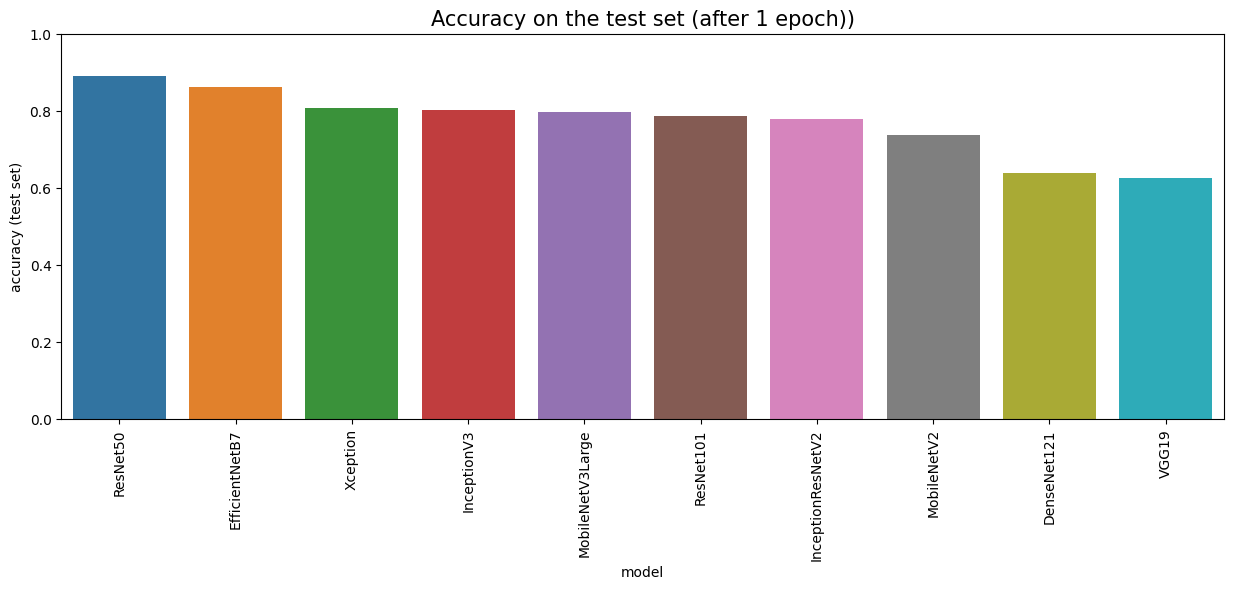

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy (test set)', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

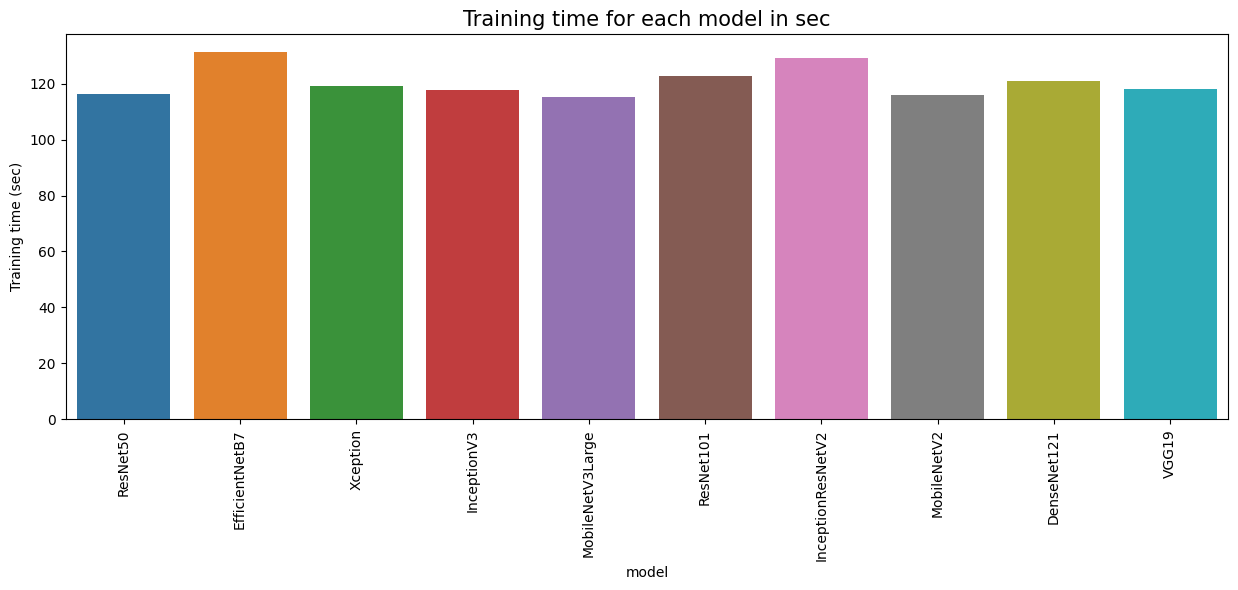

In [16]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [17]:
acc = df_results.iloc[0]['accuracy (test set)']
best_model = df_results.iloc[0]['model']
print(f'Best model: {best_model}')
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Best model: ResNet50
Accuracy on the test set: 89.10%


In [18]:
# Save the best model
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model.h5')
models[best_model]['model'].save(save_path)
print(f'Best model saved at: {save_path}')

Best model saved at: saved_models/best_model.h5


In [23]:
# Predict the labels of the test_images for the best model
pred = models[best_model]['model'].predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
models[name]['acc'] = round(acc,4)

20/20 [==============================] - 5s 255ms/step


Confusion matrix saved as /kaggle/working/confusion_matrix.png


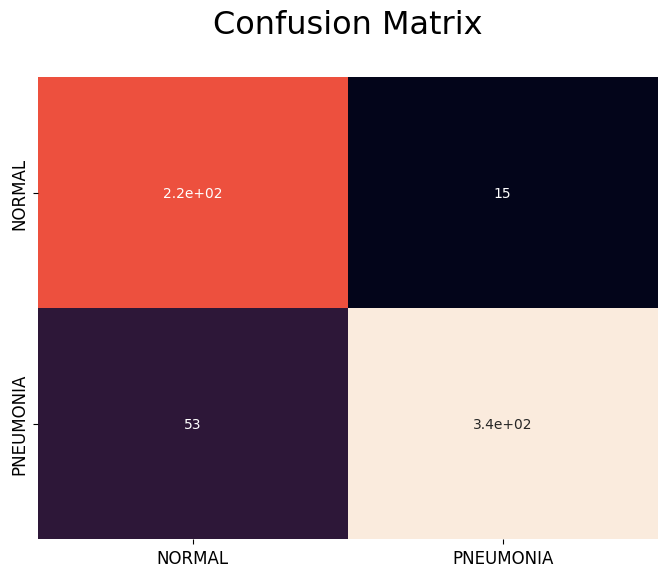

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, save_path=None):
    """
    Display a confusion matrix and save it as an image file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the confusion matrix image. If None, the image will not be saved.

    Returns:
        None
    """
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)), cbar=False)
    plt.title('Confusion Matrix\n', fontsize=23)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path is not None:
        plt.savefig(save_path)
        print(f"Confusion matrix saved as {save_path}")
    else:
        plt.show()
# Assuming you have the y_test and pred variables defined
save_path = "/kaggle/working/confusion_matrix.png"  # Set the desired save path or set it to None to only display the matrix

display_confusion_matrix(y_test, pred, save_path)

In [25]:
from sklearn.metrics import classification_report

def save_classification_report(y_true, y_pred, save_path=None):
    """
    Print the classification report and save it as a text file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the classification report. If None, the report will not be saved.

    Returns:
        None
    """
    report = classification_report(y_true, y_pred)

    print(report)

    if save_path is not None:
        with open(save_path, "w") as file:
            file.write(report)
        print(f"Classification report saved as {save_path}")


# Assuming you have the y_test and pred variables defined
save_path = "/kaggle/working/classification_report.txt"  # Set the desired save path or set it to None to only print the report

save_classification_report(y_test, pred, save_path)

              precision    recall  f1-score   support

      NORMAL       0.81      0.94      0.87       234
   PNEUMONIA       0.96      0.86      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.89       624

Classification report saved as /kaggle/working/classification_report.txt


## 5. Examples of prediction


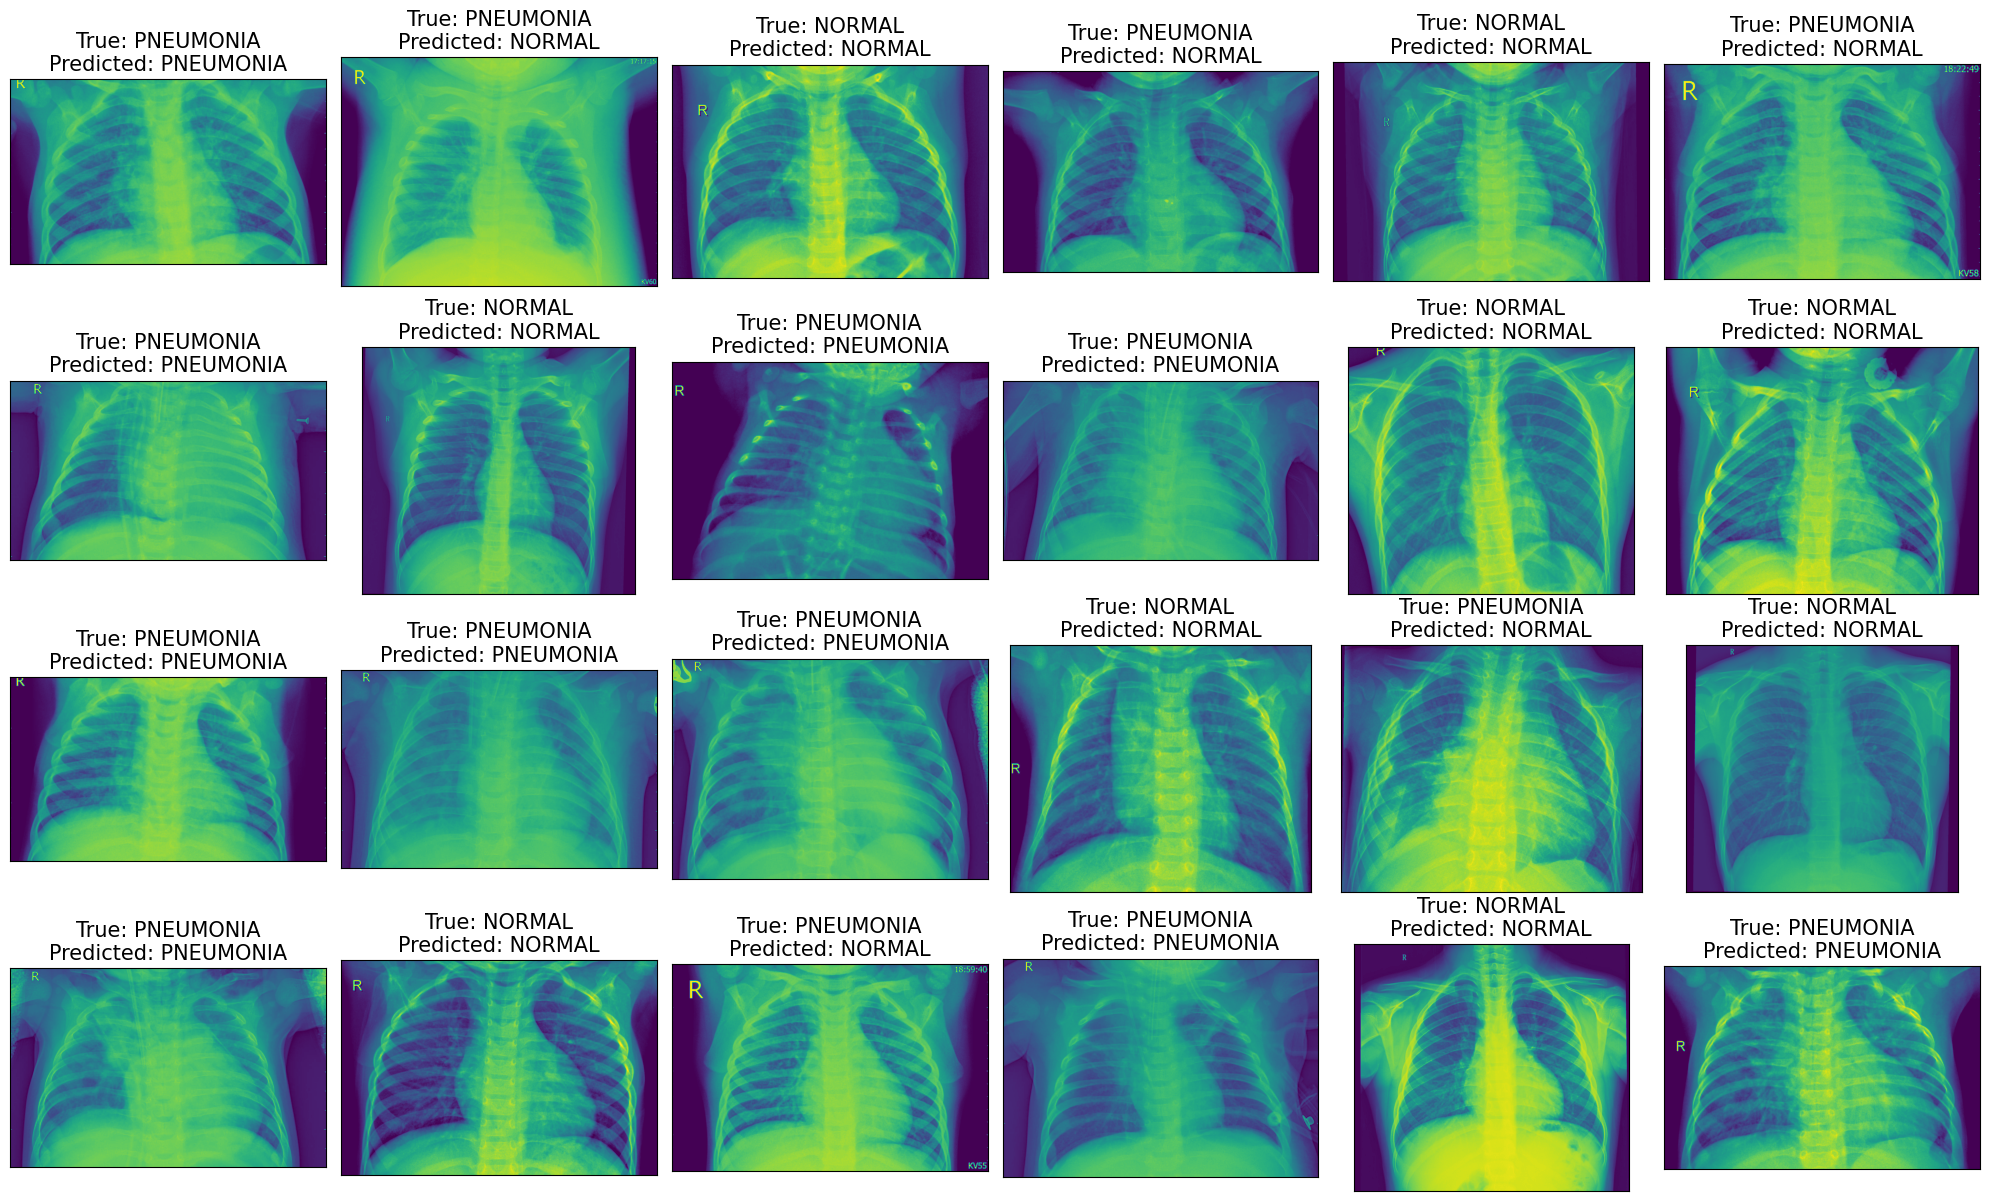

In [26]:
import matplotlib.pyplot as plt

def display_predicted_images(test_df, pred):
    """
    Display pictures of the test dataset with their True and Predicted labels.

    Args:
        test_df (pandas.DataFrame): DataFrame containing the test dataset.
        pred (list): List of predicted labels.

    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}", fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
display_predicted_images(test_df, pred)